# **Predicting emissions using the _XARIMA_ model**

In [3]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from pmdarima.arima import auto_arima
import warnings
warnings.filterwarnings('ignore')
from utils import *

In [4]:
# Read preprocessed data
data_raw = pd.read_csv('final_data.csv', index_col='Unnamed: 0', parse_dates=['date_etablissement_dpe'])

In [ ]:
# Split data according to category
data = split(data_raw)

Let's take a look at the unique dates to have an idea of the size of our time series.

In [6]:
for key in data.keys():
    print(f'Column: {key}'.ljust(19, ' ') + '--->' + f'Size = {data[key].date_etablissement_dpe.unique().shape[0]}'.rjust(12, ' '))

Column: admin      ---> Size = 4252
Column: centre_com ---> Size = 3418
Column: occup_cont ---> Size = 3246
Column: autre      ---> Size = 4043


**Aggregating columns with respect to the date column**

In [7]:
ts ={key: {freq: extract_vect_ts(df, freq) for freq in ['D', 'W', 'M']} for key, df in data.items()}

In [8]:
ts['admin']['W']  # ts['sector']['frequency']

,annee_construction,surface_utile,coord_x,coord_y,emission_ges
date_etablissement_dpe,,,,,
2013-01-13,1974.000000,100.000000,661276.385727,6.863710e+06,27.130000
2013-01-20,1974.000000,100.000000,642131.351753,6.841609e+06,27.515000
2013-01-27,1974.000000,100.000000,622986.317779,6.819508e+06,27.900000
2013-02-03,1974.000000,100.000000,603841.283805,6.797406e+06,28.285000
2013-02-10,1974.000000,100.000000,584696.249830,6.775305e+06,28.670000
...,...,...,...,...,...
2024-12-08,1966.110170,234.024132,675958.215238,6.663887e+06,11.360938
2024-12-15,1966.023341,177.840398,661427.597506,6.661860e+06,8.770826
2024-12-22,1965.049847,173.369254,651383.875067,6.653682e+06,9.580173


_Remark:_ For the resampling step, only 156 rows out of our 4375 rows were interpolated, the remaining rows were already present in the dataset.

**Prediction and validation**

Before predicting let's define a function that splits our data into a train time series and test time series (it can be found in `aggregate.py`).

Now let's apply our model to predict ts_admin values. First let's do a train test split for every time series.

In [9]:
for sect in ts:
    for freq in ts[sect]:
        train, test = ttsplit(ts[sect][freq])
        ts[sect][freq] = {'train': train, 'test': test}

In [10]:
ts['admin']['W']['train'].tail()

,annee_construction,surface_utile,coord_x,coord_y,emission_ges
date_etablissement_dpe,,,,,
2021-12-05,1973.443051,294.061644,669780.954562,6.610451e+06,9.323881
2021-12-12,1970.556142,250.735492,654698.968087,6.647732e+06,10.502186
2021-12-19,1971.476040,466.225404,651926.460193,6.639262e+06,10.352466
2021-12-26,1969.239052,280.367678,645668.676023,6.704144e+06,11.452941
2022-01-02,1964.616258,149.333108,658101.675612,6.669188e+06,12.024793


In [11]:
ts['admin']['W']['test'].head()

,annee_construction,surface_utile,coord_x,coord_y,emission_ges
date_etablissement_dpe,,,,,
2022-01-09,1969.312994,520.815215,620617.402066,6.670510e+06,12.948173
2022-01-16,1969.147755,361.690374,664686.816562,6.624619e+06,12.886822
2022-01-23,1974.686615,216.371506,648555.047141,6.668022e+06,11.216982
2022-01-30,1967.878830,244.195668,633763.196287,6.642269e+06,9.623095
2022-02-06,1968.647627,251.551112,696000.296617,6.622129e+06,10.534374


In [12]:
for sect in ts:
    for freq in ts[sect]:
        train, test = ts[sect][freq]['train'], ts[sect][freq]['test']
        model = ARIMA(endog=train.emission_ges, exog=train.drop(columns='emission_ges'), order=(0, 1, 2))
        model_fit = model.fit()
        pred = model_fit.forecast(steps=len(test), exog=test.drop(columns='emission_ges'))
        ts[sect][freq]['pred'] = pred

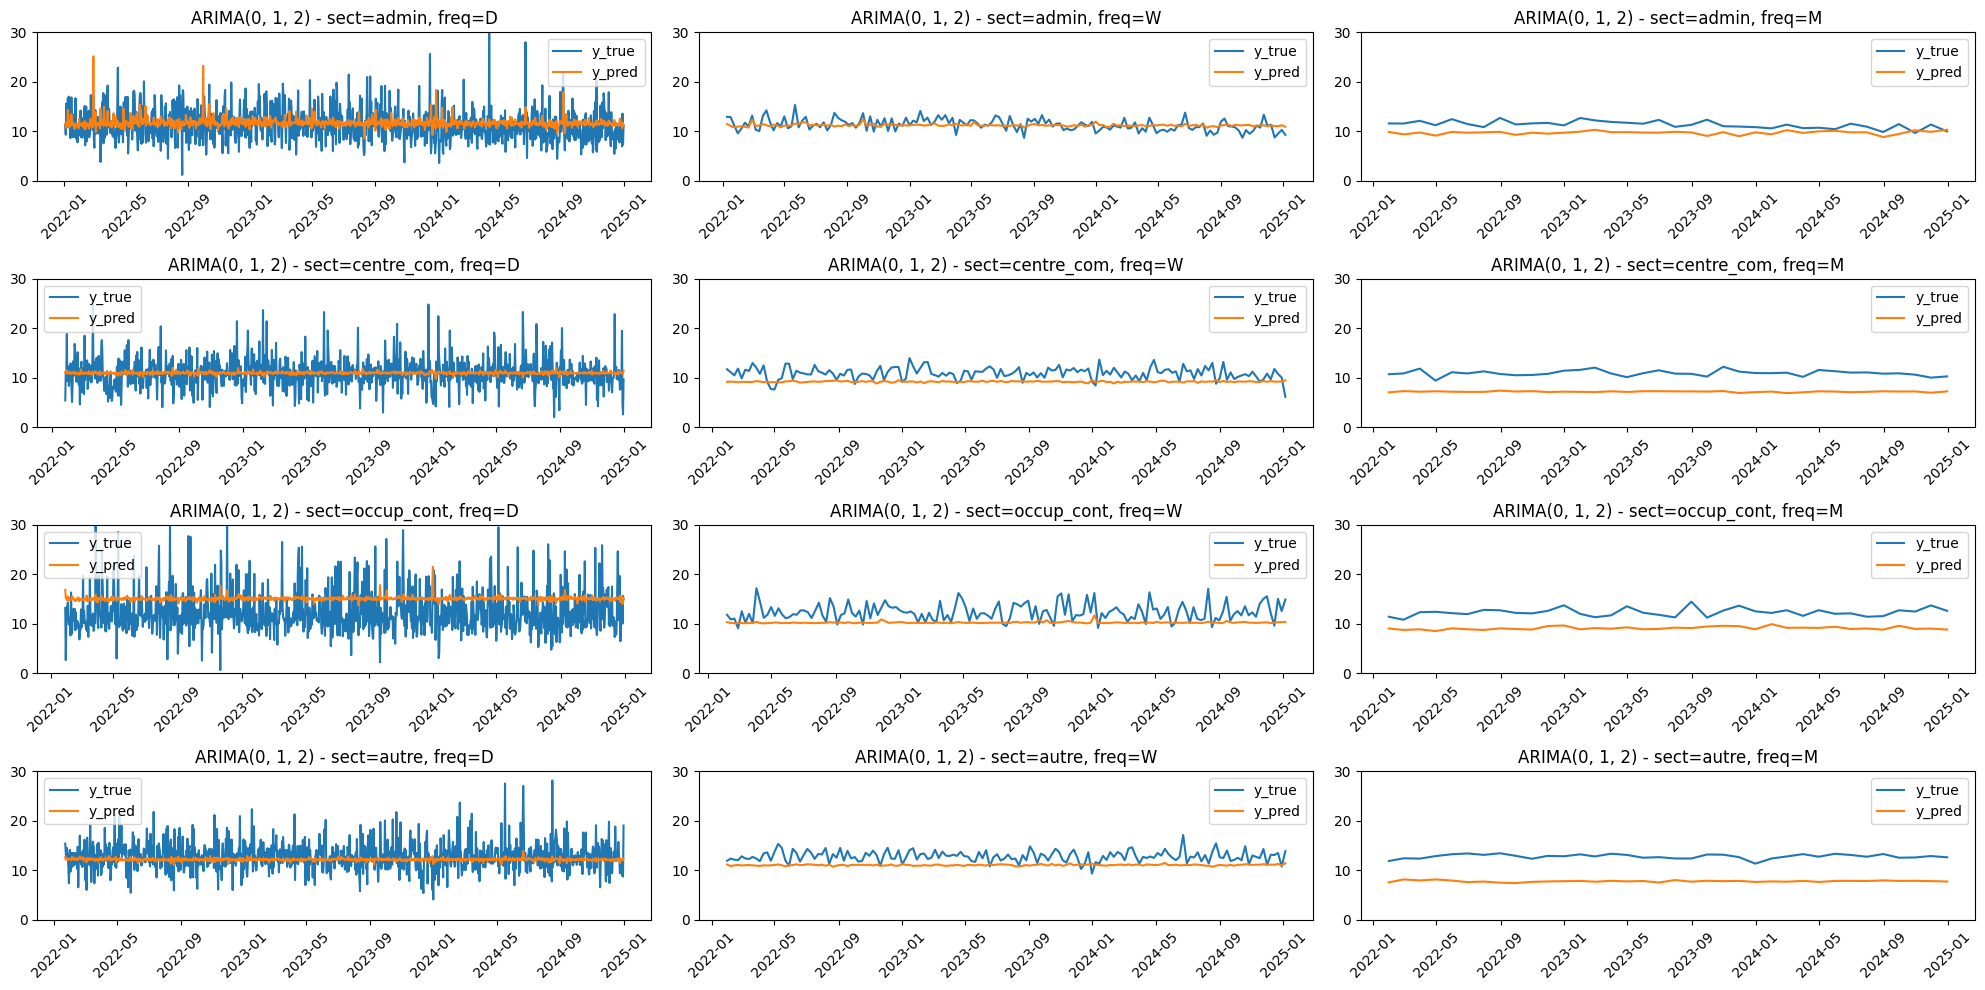

In [13]:
n, m = 4, 3
fig, axs = plt.subplots(n, m, figsize=(20,10))
for i, sect in enumerate(ts):
    for j, freq in enumerate(ts[sect]):
        train, test, pred = ts[sect][freq].values()
        n = len(test)
        axs[i, j].plot(test.emission_ges, label='y_true')
        axs[i, j].plot(pred, label='y_pred')
        axs[i, j].legend()
        axs[i, j].set_title(f'ARIMA(0, 1, 2) - sect={sect}, freq={freq}')
        axs[i, j].set_ylim(0, 30)
        plt.setp(axs[i, j].get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

In [14]:
rmse = pd.DataFrame({sect: {freq: f'{mean_squared_error(y_true=ts[sect][freq]['test'].emission_ges, y_pred=ts[sect][freq]['pred']):05.2f}' for freq in ts[sect]} for sect in ts })
rmse

,admin,centre_com,occup_cont,autre
D,10.01,08.22,24.29,08.00
W,01.37,04.41,07.39,04.35
M,03.24,14.31,10.87,25.27


It seems that with a _weekly_ frequency, we get the best fits.

**Comparing models**

In [15]:
orders = [(0, 1, 1), (0, 1, 2), (1, 1, 1), (0, 1, 3)]

for sect in ts:
    for freq in ts[sect]:
        ts[sect][freq]['pred'] = {}
        for order in orders:
            train, test = ts[sect][freq]['train'], ts[sect][freq]['test']
            model = ARIMA(endog=train.emission_ges, exog=train.drop(columns='emission_ges'), order=order)
            model_fit = model.fit()
            pred = model_fit.forecast(steps=len(test), exog=test.drop(columns='emission_ges'))
            ts[sect][freq]['pred'][order] = pred

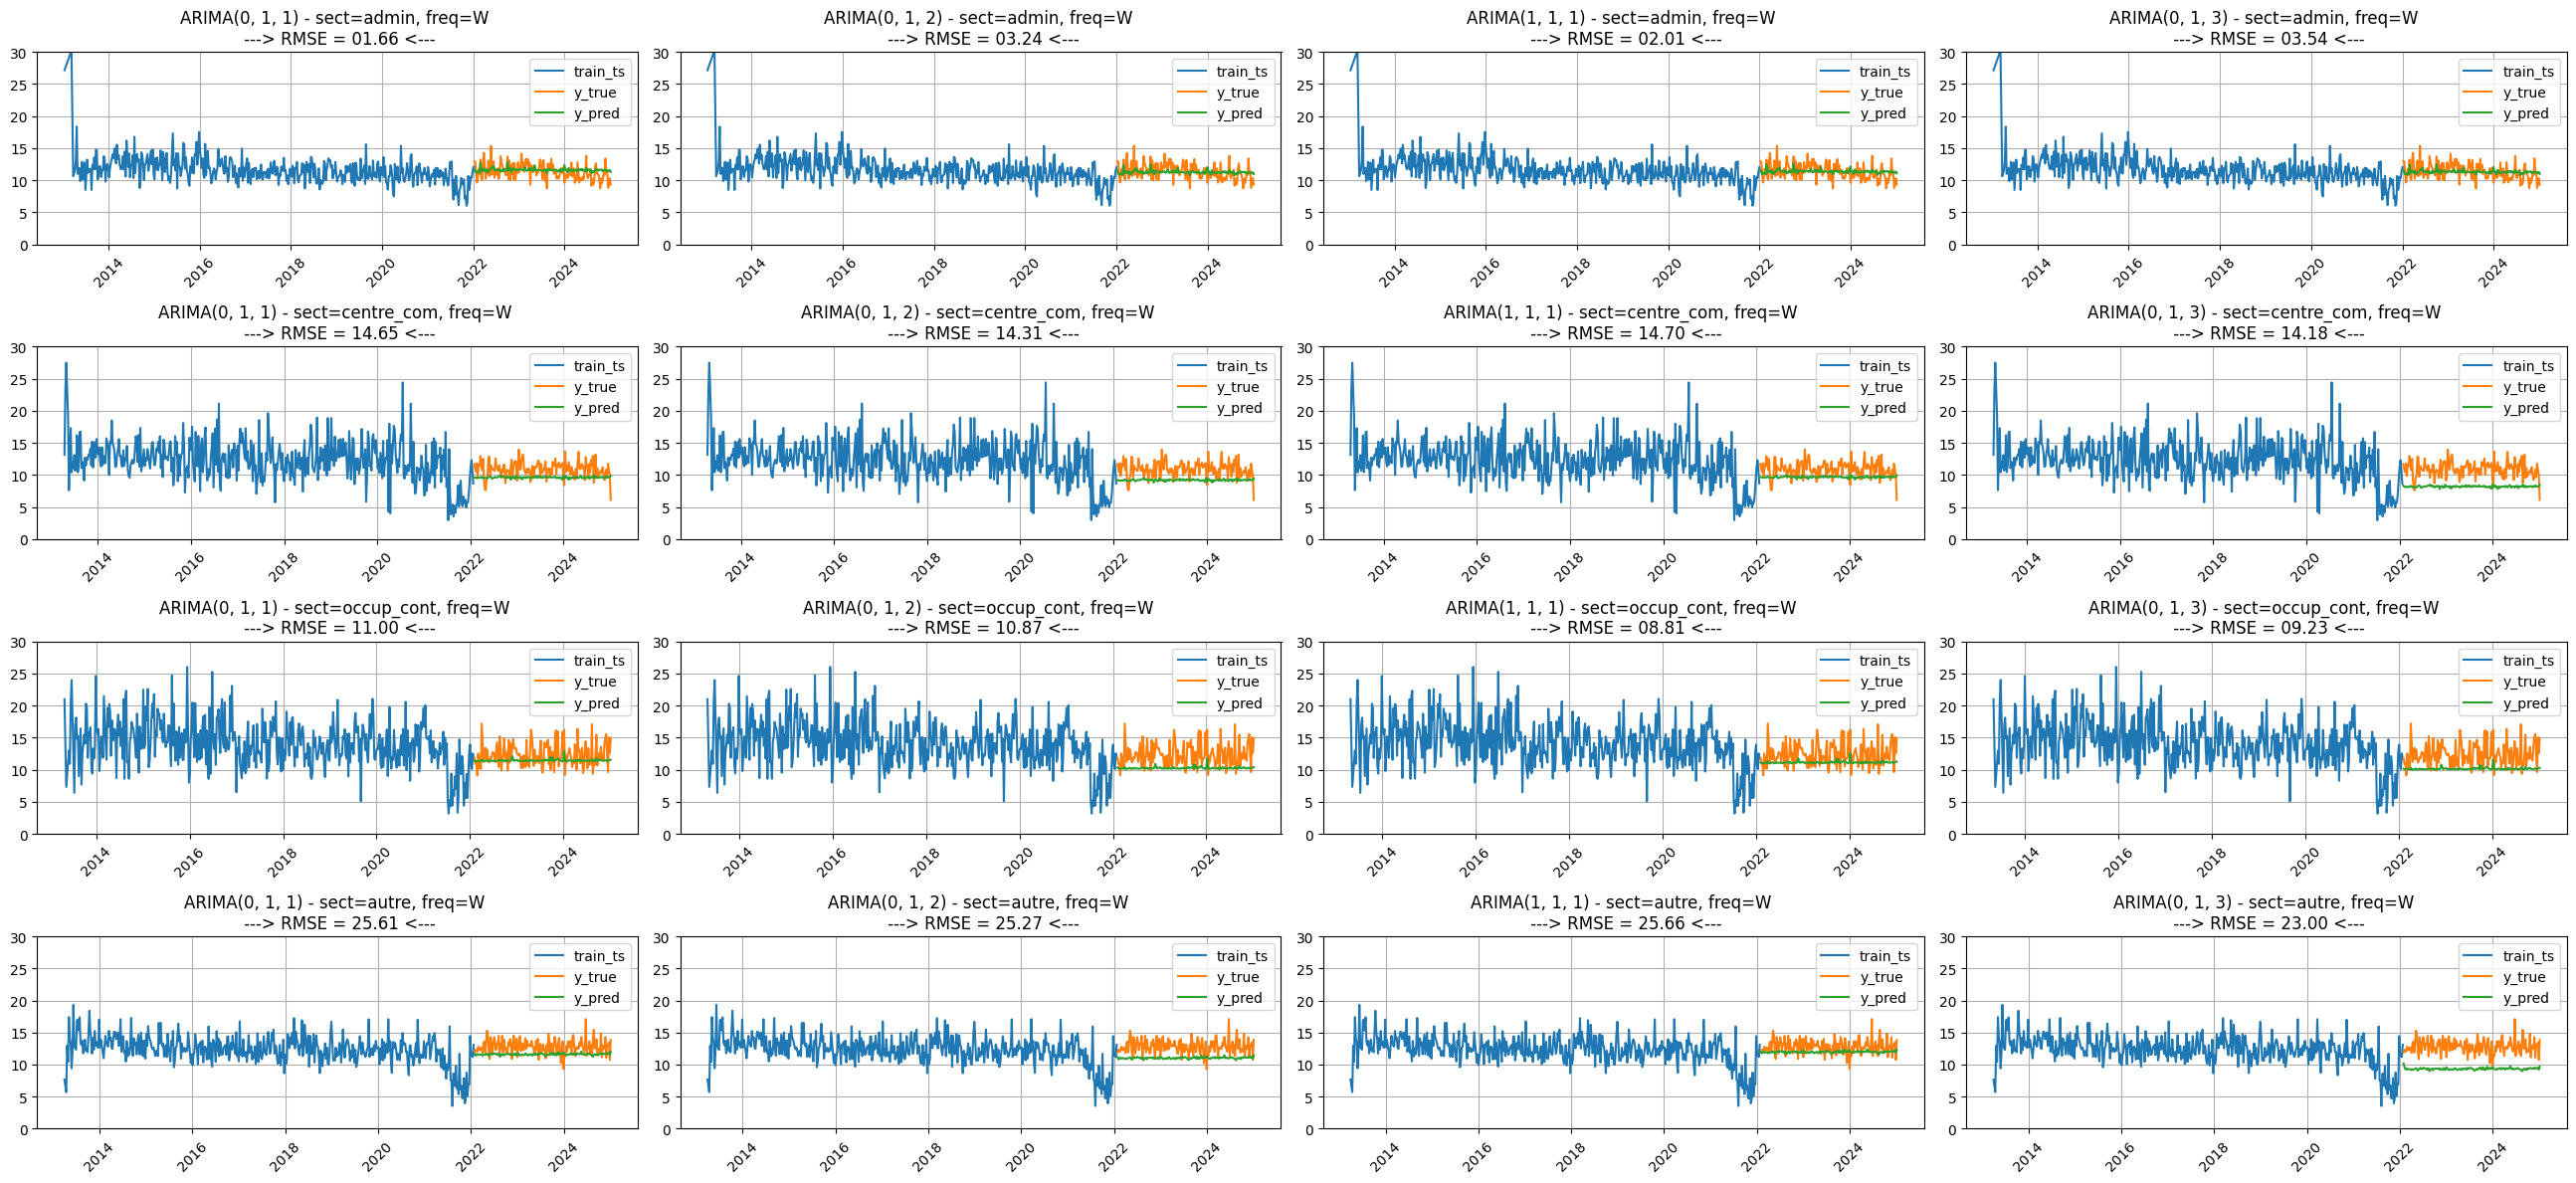

In [16]:
n, m = 4, 4
fig, axs = plt.subplots(n, m, figsize=(26,12))

for i, sect in enumerate(ts):
    for j, order in enumerate(ts[sect]['W']['pred']):
        train, test, pred = ts[sect]['W']['train'], ts[sect]['W']['test'], ts[sect]['W']['pred'][order]
        train_extended = extend_train(train, test)
        n = len(test)
        axs[i, j].plot(train_extended.emission_ges, label='train_ts')
        axs[i, j].plot(test.emission_ges, label='y_true')
        axs[i, j].plot(pred, label='y_pred')
        axs[i, j].legend()
        rmse = f'{mean_squared_error(y_true=ts[sect][freq]['test'].emission_ges, y_pred=ts[sect][freq]['pred'][order]):05.2f}'
        axs[i, j].set_title(f'ARIMA{order} - sect={sect}, freq=W \n ---> RMSE = {rmse} <---')
        axs[i, j].set_ylim(0, 30)
        axs[i, j].grid(True)
        plt.setp(axs[i, j].get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

We can see that our orders (0, 1, 2) is pretty solid compared to neighboring orders.

- Let's now check out the global trend using our model.

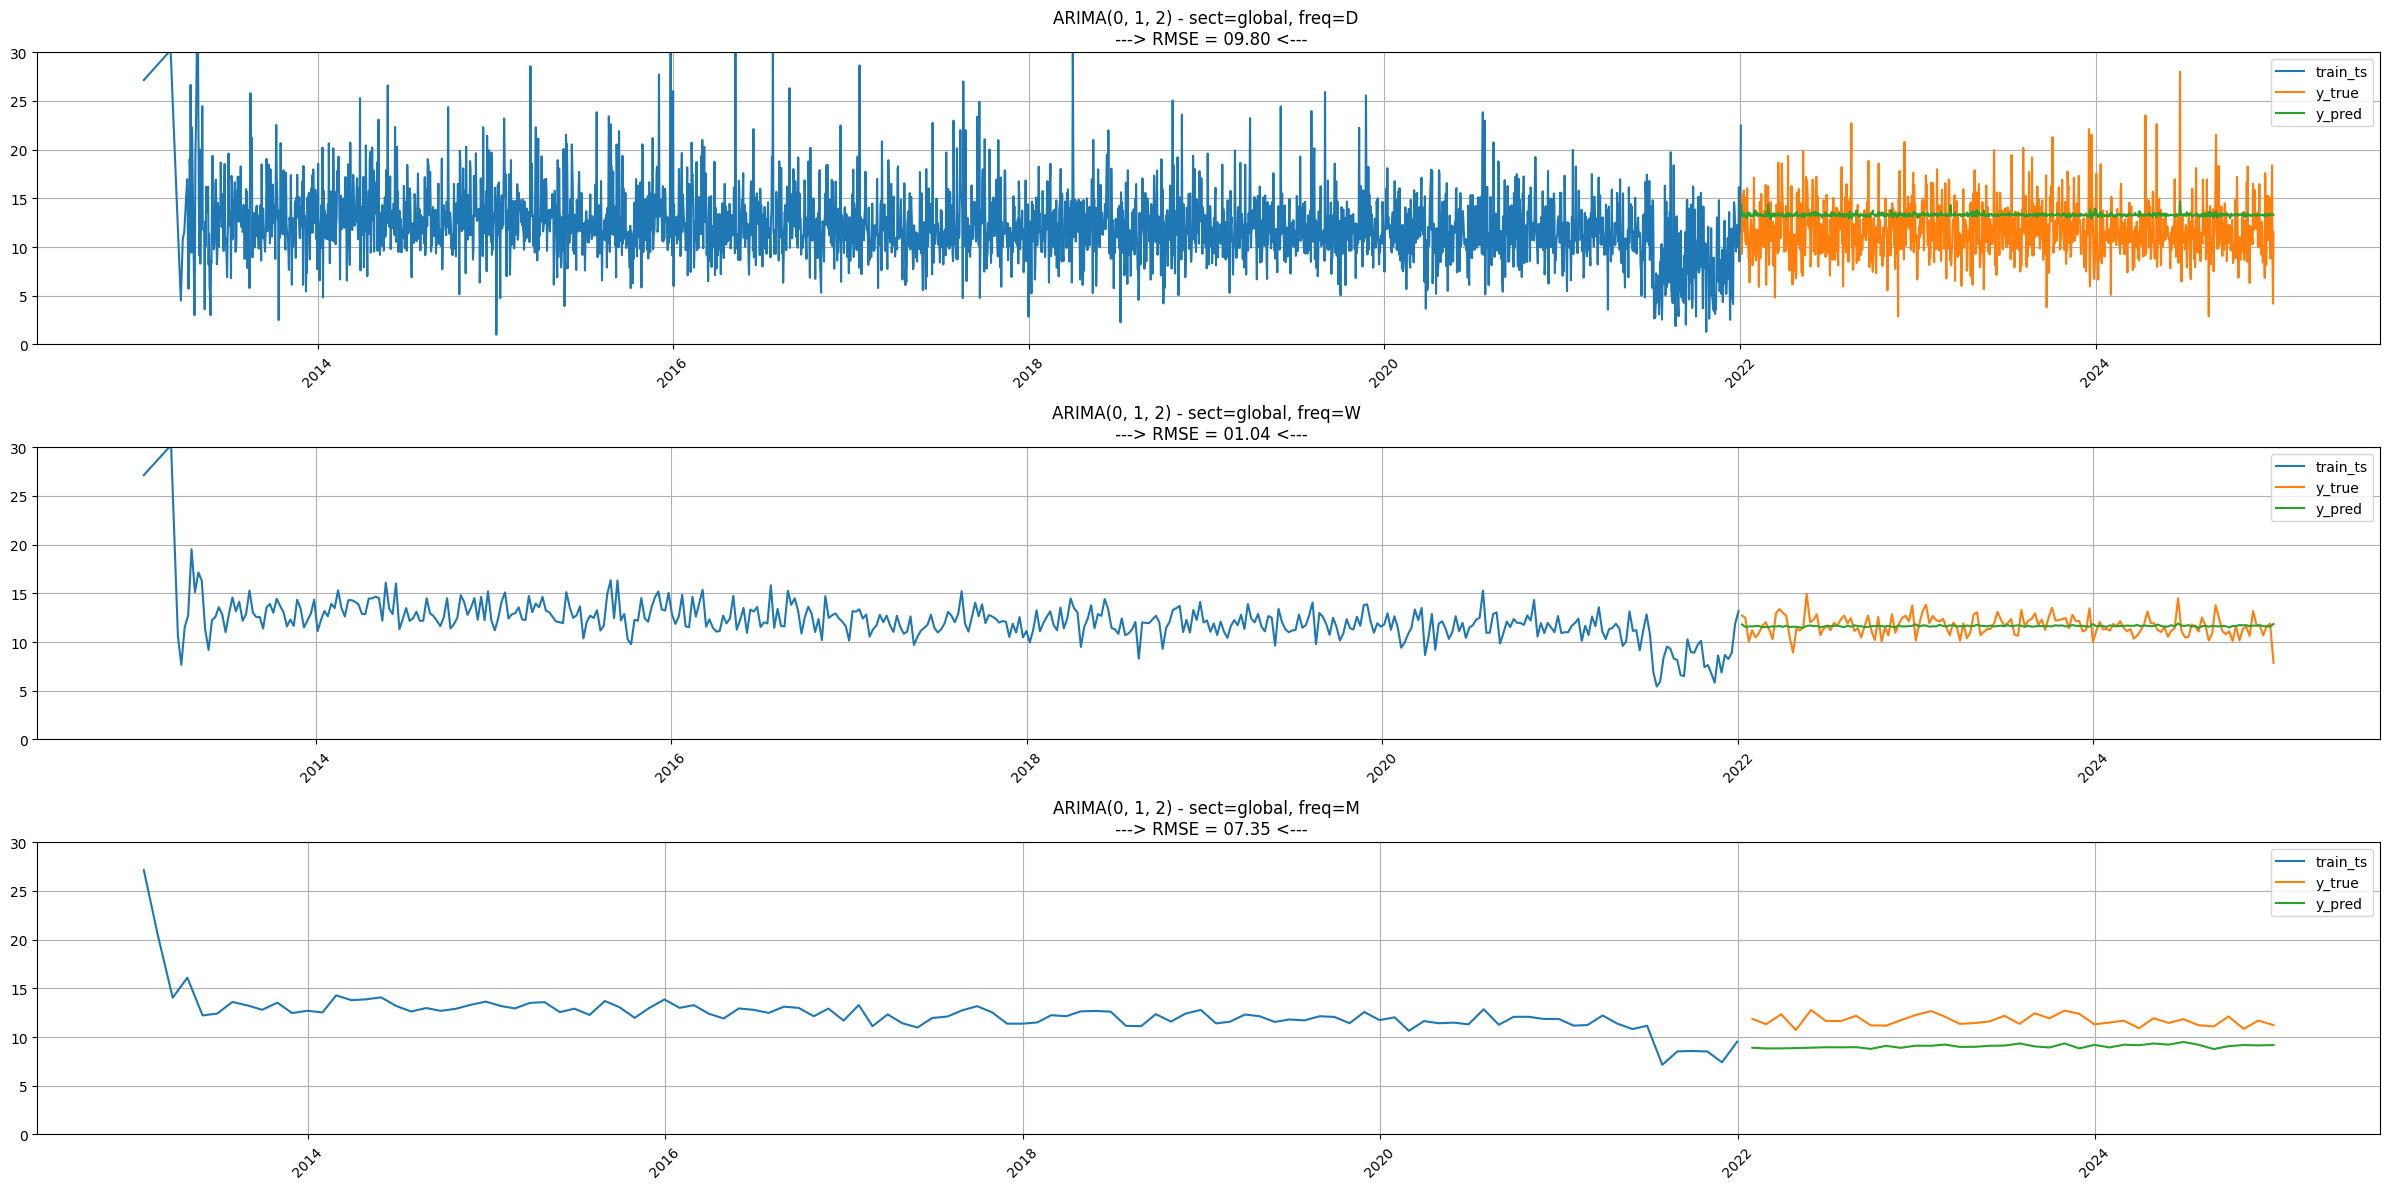

In [17]:
n, m = 3, 1
fig, axs = plt.subplots(n, m, figsize=(24,12))

global_ts = {}
for i, freq in enumerate(['D', 'W', 'M']):
    global_ts_freq = extract_vect_ts(data_raw, freq=freq)
    train, test = ttsplit(global_ts_freq)
    train_extended = extend_train(train, test)
    model = ARIMA(endog=train.emission_ges, exog=train.drop(columns='emission_ges'), order=(0, 1, 2))
    model_fit = model.fit()
    pred = model_fit.forecast(steps=len(test), exog=test.drop(columns='emission_ges'))
    axs[i].plot(train_extended.emission_ges, label='train_ts')
    axs[i].plot(test.emission_ges, label='y_true')
    axs[i].plot(pred, label='y_pred')
    axs[i].legend()
    rmse = f'{mean_squared_error(y_true=test.emission_ges, y_pred=pred):05.2f}'
    axs[i].set_title(f'ARIMA(0, 1, 2) - sect=global, freq={freq} \n ---> RMSE = {rmse} <---')
    axs[i].set_ylim(0, 30)
    axs[i].grid(True)
    plt.setp(axs[i].get_xticklabels(), rotation=45)
    global_ts[freq] = {'train': train, 'test': test, 'pred': pred}
plt.tight_layout()
plt.show()

**Using auto-arima**

In [18]:
model = auto_arima(y=global_ts['W']['train'].emission_ges, X=global_ts['W']['train'].drop(columns='emission_ges'), trace=True)  # Result: ARIMA(2, 1, 1)(0, 0, 0)[0]

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2263.084, Time=1.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1891.097, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1855.792, Time=0.68 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1843.349, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4299.696, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1835.108, Time=0.56 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1834.298, Time=0.75 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1848.580, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1844.597, Time=1.31 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2516.013, Time=0.44 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1845.541, Time=1.41 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1906.952, Time=1.33 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1830.102, Time=0.54 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1833.178, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0]          

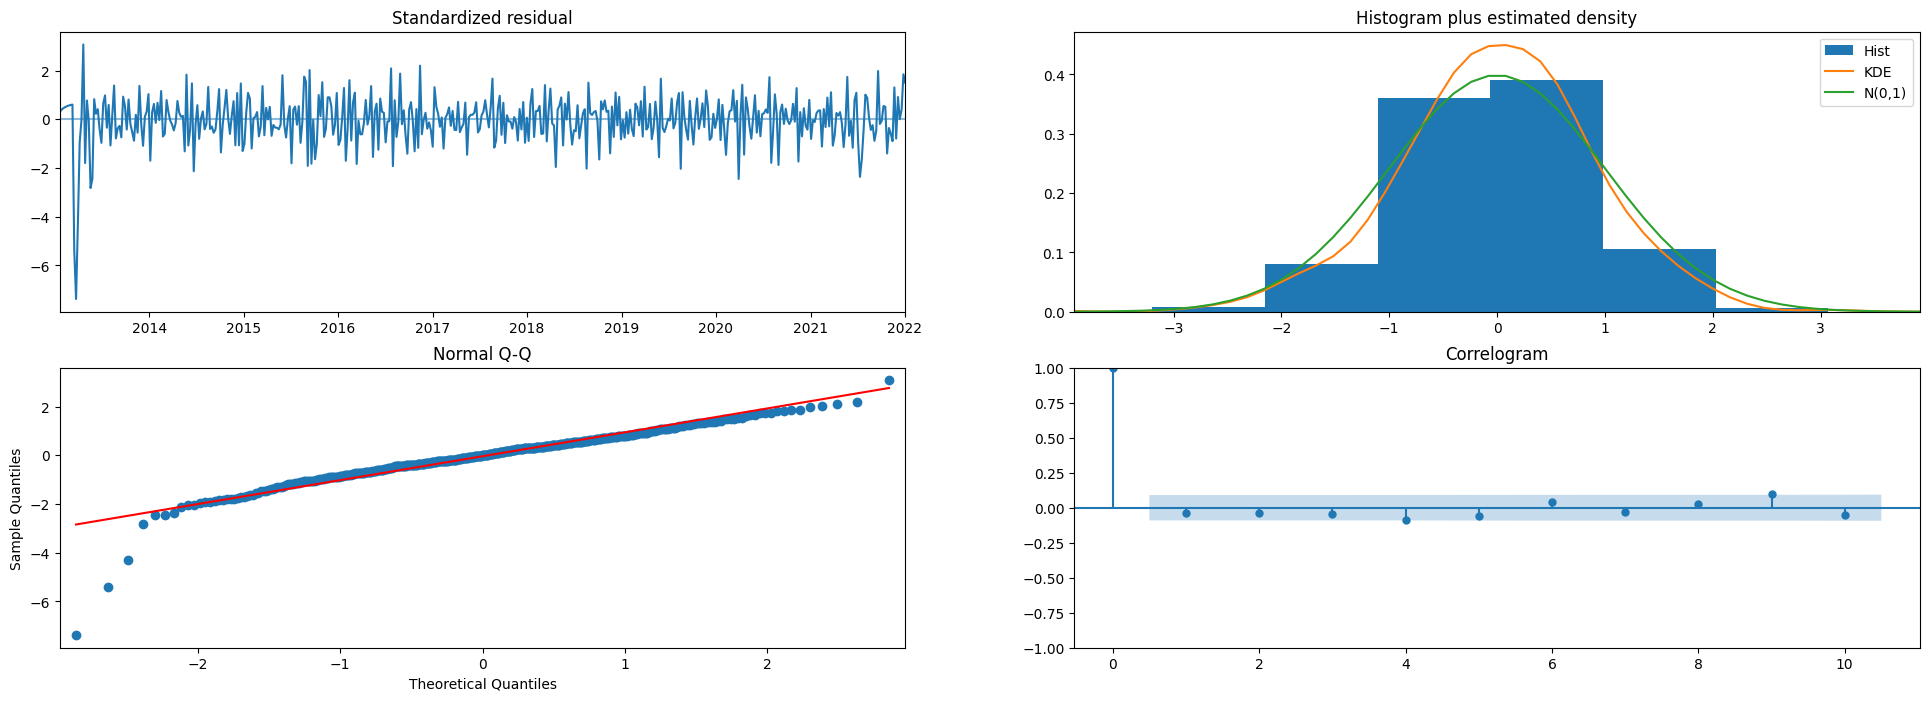

In [19]:
model.plot_diagnostics(figsize=(24, 8))
plt.show()

In [20]:
pred = model.predict(n_periods=len(global_ts['W']['test']), X=global_ts['W']['test'].drop(columns='emission_ges'))
global_ts['W']['pred'] = pred

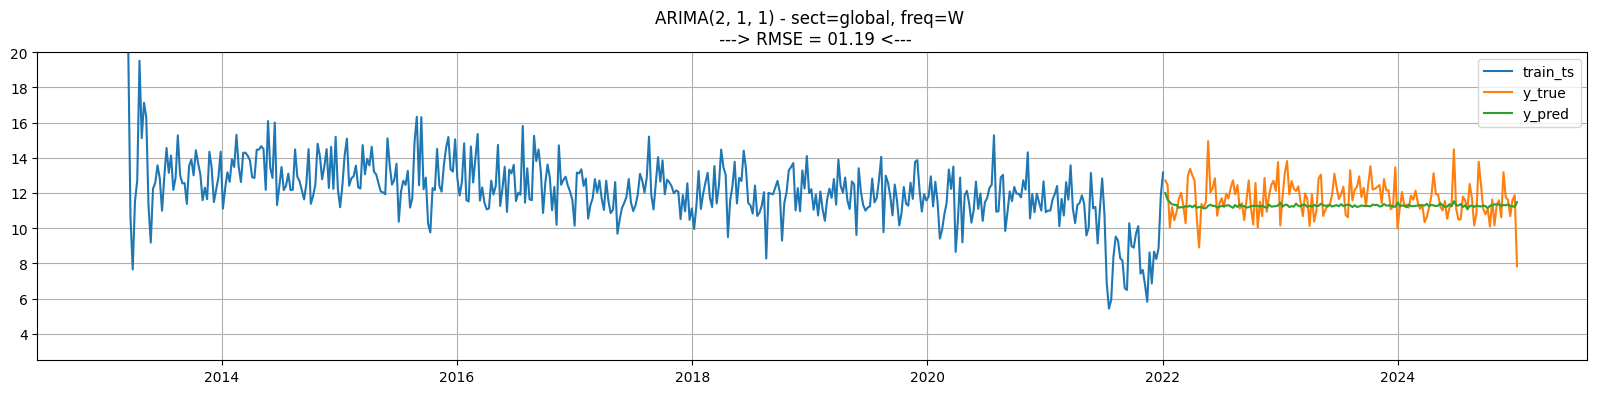

In [21]:
fig = plt.figure(figsize=(20, 4))
rmse = f'{mean_squared_error(y_true=global_ts['W']['test'].emission_ges, y_pred=global_ts['W']['pred']):05.2f}'
plt.plot(extend_train(global_ts['W']['train'], global_ts['W']['test']).emission_ges, label='train_ts')
plt.plot(global_ts['W']['test'].emission_ges, label='y_true')
plt.plot(global_ts['W']['pred'], label='y_pred')
plt.ylim(2.5, 20)
plt.grid(True)
plt.legend()
plt.title(f'ARIMA(2, 1, 1) - sect=global, freq=W \n ---> RMSE = {rmse} <---')
plt.show()

**Rolling mean approach**

In [22]:
smooth_global_ts_w = {tt: rolling_average(global_ts['W'][tt], window=10) for tt in ['train', 'test']}  
pred = model.predict(n_periods=len(smooth_global_ts_w['test']), X=smooth_global_ts_w['test'].drop(columns='emission_ges'))
smooth_global_ts_w['pred'] = pred

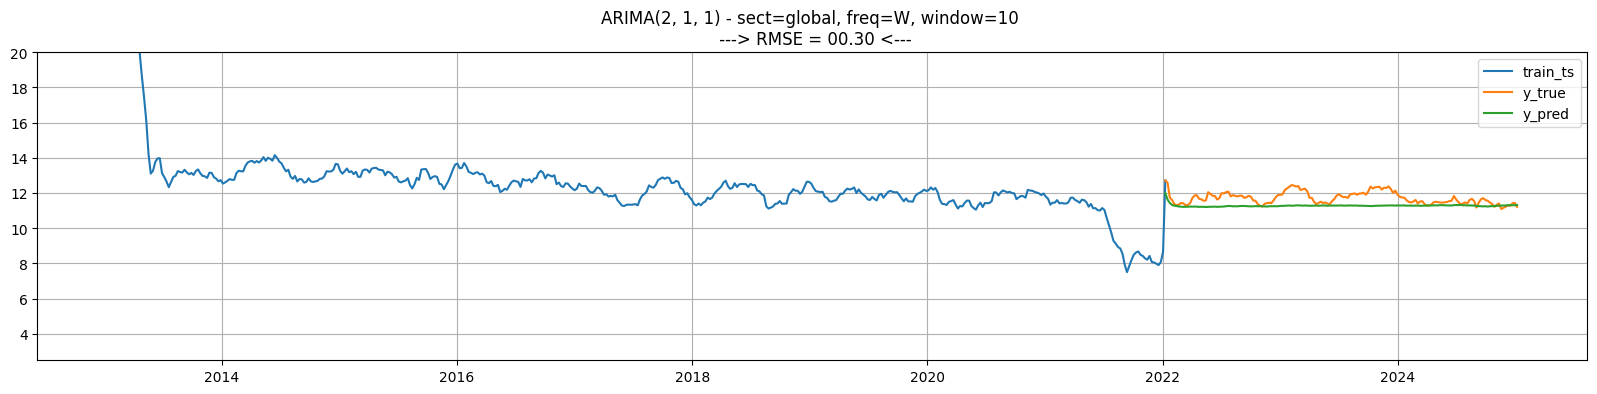

In [23]:
fig = plt.figure(figsize=(20, 4))
rmse = f'{mean_squared_error(y_true=smooth_global_ts_w['test'].emission_ges, y_pred=smooth_global_ts_w['pred']):05.2f}'
train, test, pred = smooth_global_ts_w['train'].emission_ges, smooth_global_ts_w['test'].emission_ges, smooth_global_ts_w['pred']
train_extended = extend_train(train, test)
plt.plot(train_extended, label='train_ts')
plt.plot(test, label='y_true')
plt.plot(pred, label='y_pred')
plt.ylim(2.5, 20)
plt.grid(True)
plt.legend()
plt.title(f'ARIMA(2, 1, 1) - sect=global, freq=W, window=10 \n ---> RMSE = {rmse} <---')
plt.show()

We can clearly see that this rolling average approach yields better results for the general trend and by far the smallest RMSE (0.30).